# Analiza i Wizualizacja Dobowych Średnich Zanieczyszczeń Powietrza

Ten notatnik służy do pobierania przetworzonych danych z tabeli `daily_averages` w bazie danych Cassandra, a następnie do tworzenia wizualizacji w celu analizy trendów i wzorców.

### 1. Importowanie niezbędnych bibliotek

In [7]:
import os
from dotenv import load_dotenv
import pandas as pd
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 2. Konfiguracja połączenia z bazą danych Cassandra

Poniższy kod ładuje dane uwierzytelniające z pliku `.env` i nawiązuje połączenie z klastrem Cassandra. 

**Uwaga:** Upewnij się, że plik `.env` znajduje się w głównym katalogu projektu i zawiera `DATABASE_USER` oraz `DATABASE_PASSWORD`. Zaktualizuj również listę `CASSANDRA_CONTACT_POINTS`, podając publiczne adresy IP Twoich węzłów w klastrze.

In [8]:
# Załaduj zmienne środowiskowe z pliku .env
load_dotenv(dotenv_path='../.env')

# Pobierz dane uwierzytelniające z zmiennych środowiskowych
db_user = os.getenv('DATABASE_USER')
db_password = os.getenv('DATABASE_PASSWORD')
cassandra_node = os.getenv('CASSANDRA_NODE_IP')

CASSANDRA_CONTACT_POINTS = [ip.strip() for ip in cassandra_node.split(',') if ip.strip()]

KEYSPACE = 'air_quality'

# Ustawienie providera autoryzacji
auth_provider = PlainTextAuthProvider(username=db_user, password=db_password)

# Nawiązanie połączenia
cluster = Cluster(CASSANDRA_CONTACT_POINTS, auth_provider=auth_provider)
session = cluster.connect(KEYSPACE)

print("Połączenie z bazą danych Cassandra zostało nawiązane.")

Połączenie z bazą danych Cassandra zostało nawiązane.


### 3. Pobieranie danych i tworzenie ramki danych (DataFrame)

Pobieramy wszystkie dane z tabeli `daily_averages` i konwertujemy je do ramki danych biblioteki Pandas w celu łatwiejszej manipulacji i analizy.

In [9]:
query = "SELECT * FROM daily_averages;"
rows = session.execute(query)

# Konwersja wyników do listy słowników
data = [row._asdict() for row in rows]

# Tworzenie DataFrame
df = pd.DataFrame(data)

# Konwersja kolumny 'day' na typ datetime
df['day'] = pd.to_datetime(df['day'].apply(str))

# Sortowanie danych dla lepszej wizualizacji
df = df.sort_values(by=['station_id', 'parameter', 'day'])

print(f"Pobrano {len(df)} wierszy danych.")
df.head()

Pobrano 12633 wierszy danych.


,station_id,day,avg_value,name,parameter,unit
7055,10181,2017-02-21,13.900000,"Zabrze, ul. M. Curie-Skłodowskiej\n",no2,µg/m³
7054,10181,2017-02-22,8.000000,"Zabrze, ul. M. Curie-Skłodowskiej\n",no2,µg/m³
7053,10181,2017-02-23,20.760000,"Zabrze, ul. M. Curie-Skłodowskiej\n",no2,µg/m³
7052,10181,2017-02-24,22.136250,"Zabrze, ul. M. Curie-Skłodowskiej\n",no2,µg/m³
7051,10181,2017-02-25,20.733749,"Zabrze, ul. M. Curie-Skłodowskiej\n",no2,µg/m³


### 4. Wizualizacja Danych

Tworzymy wykresy liniowe pokazujące zmiany średniej dobowej wartości dla każdego parametru w każdej stacji pomiarowej.

Znaleziono stacje: ['10181' '10516' '10542' '7274' '7856' '9076' '9464' '9465' '9546' '9550'
 '9555']
Znaleziono parametry: ['no2' 'pm10' 'so2' 'pm25' 'o3']


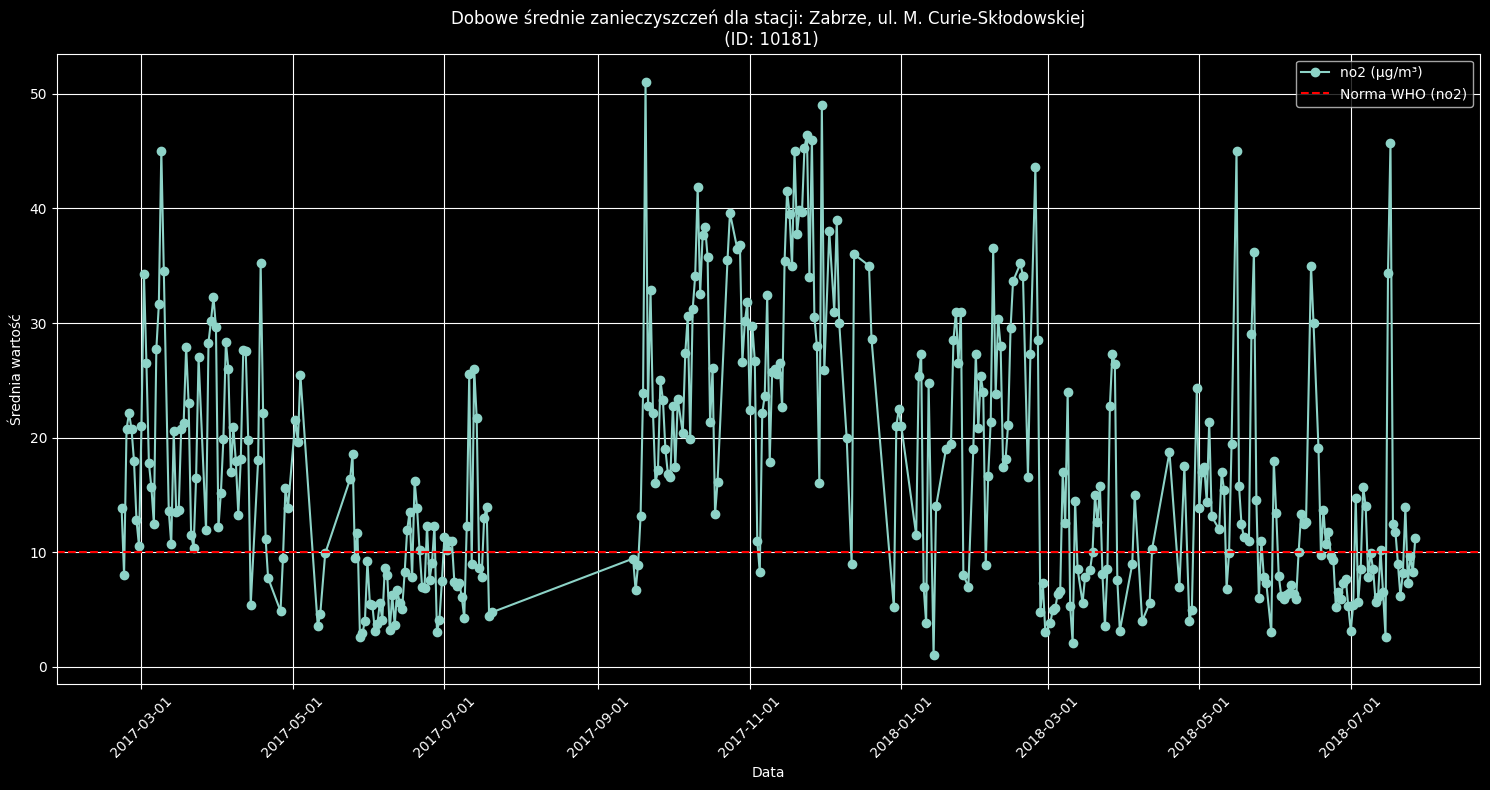

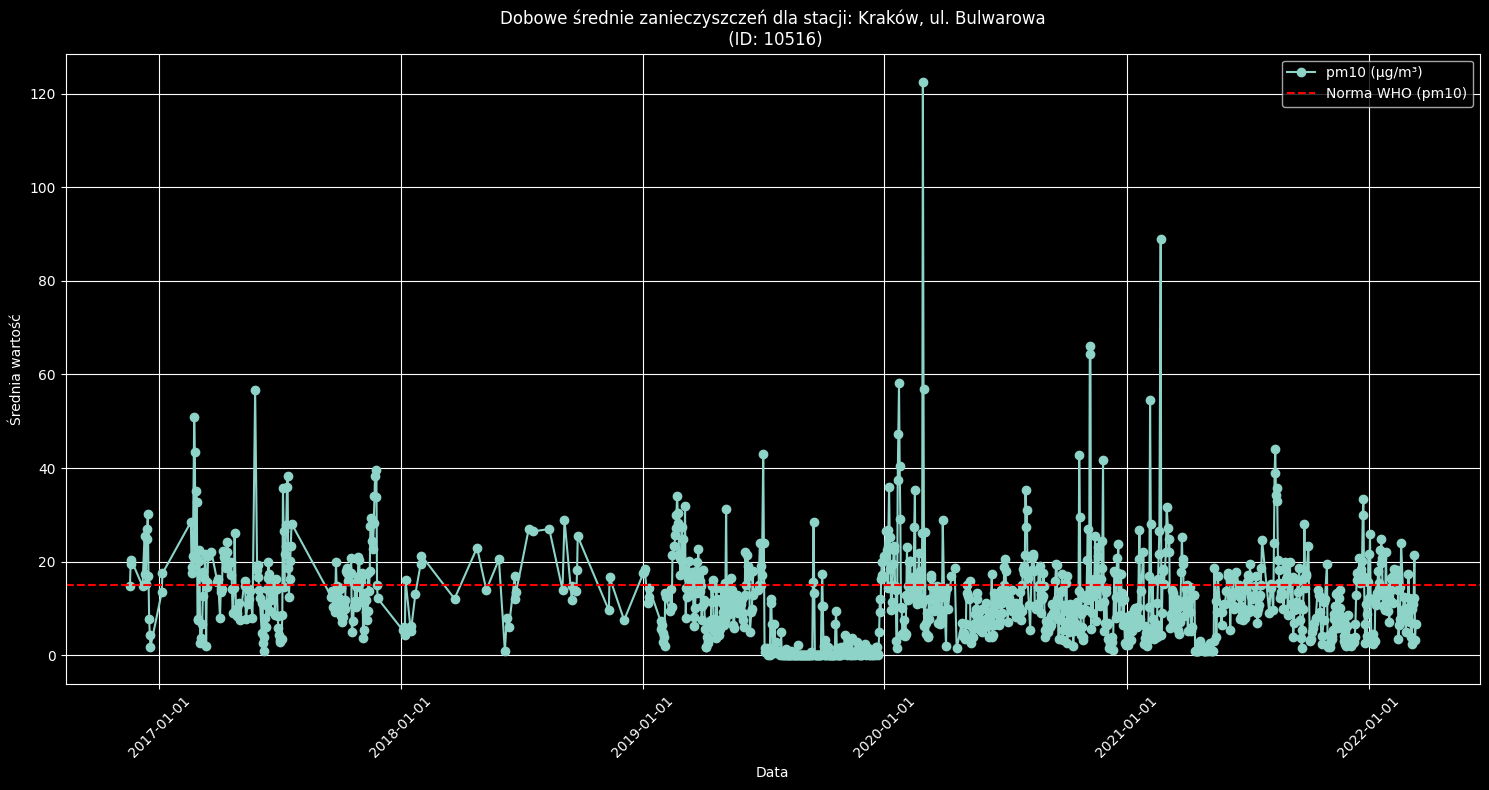

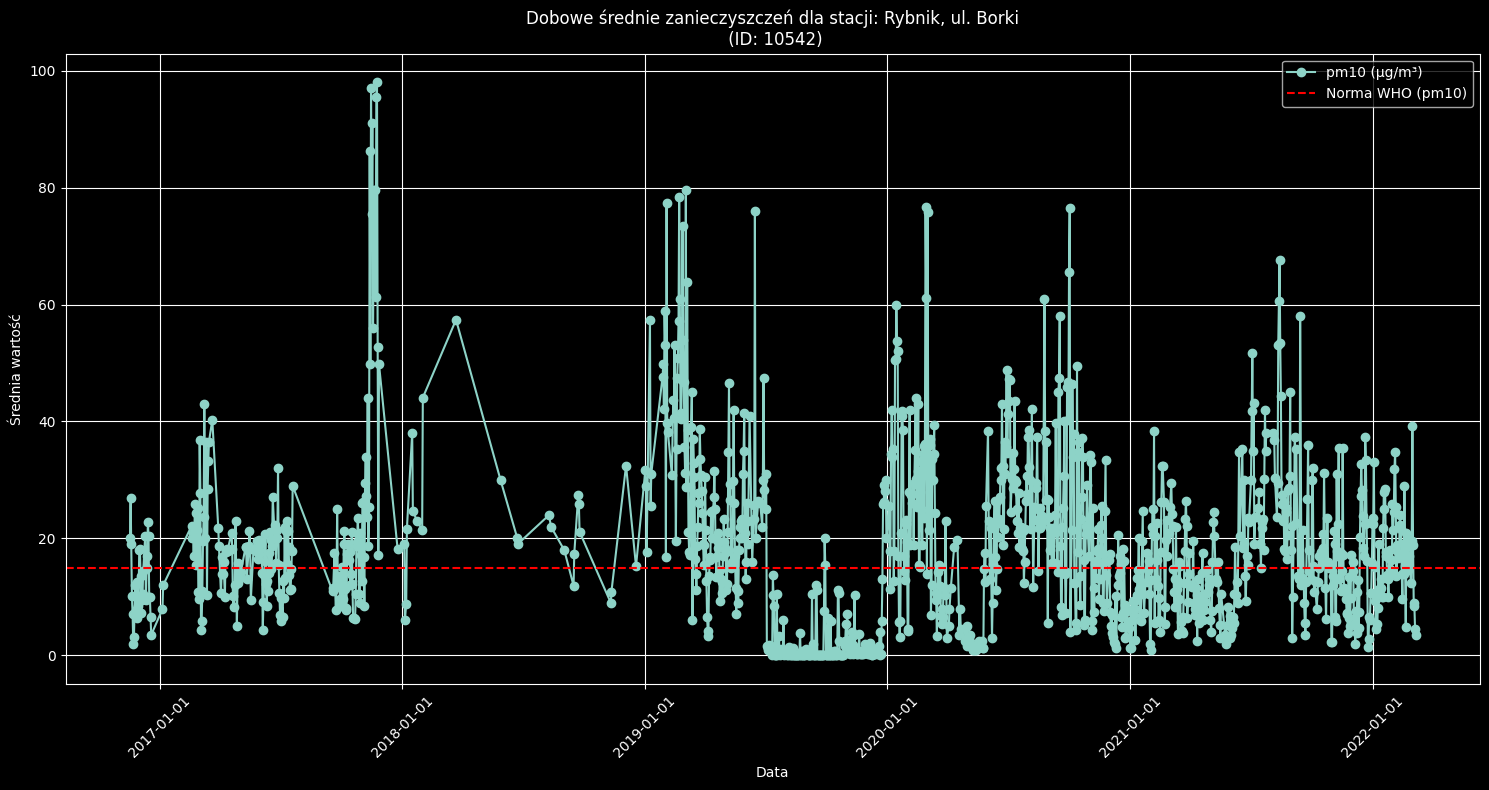

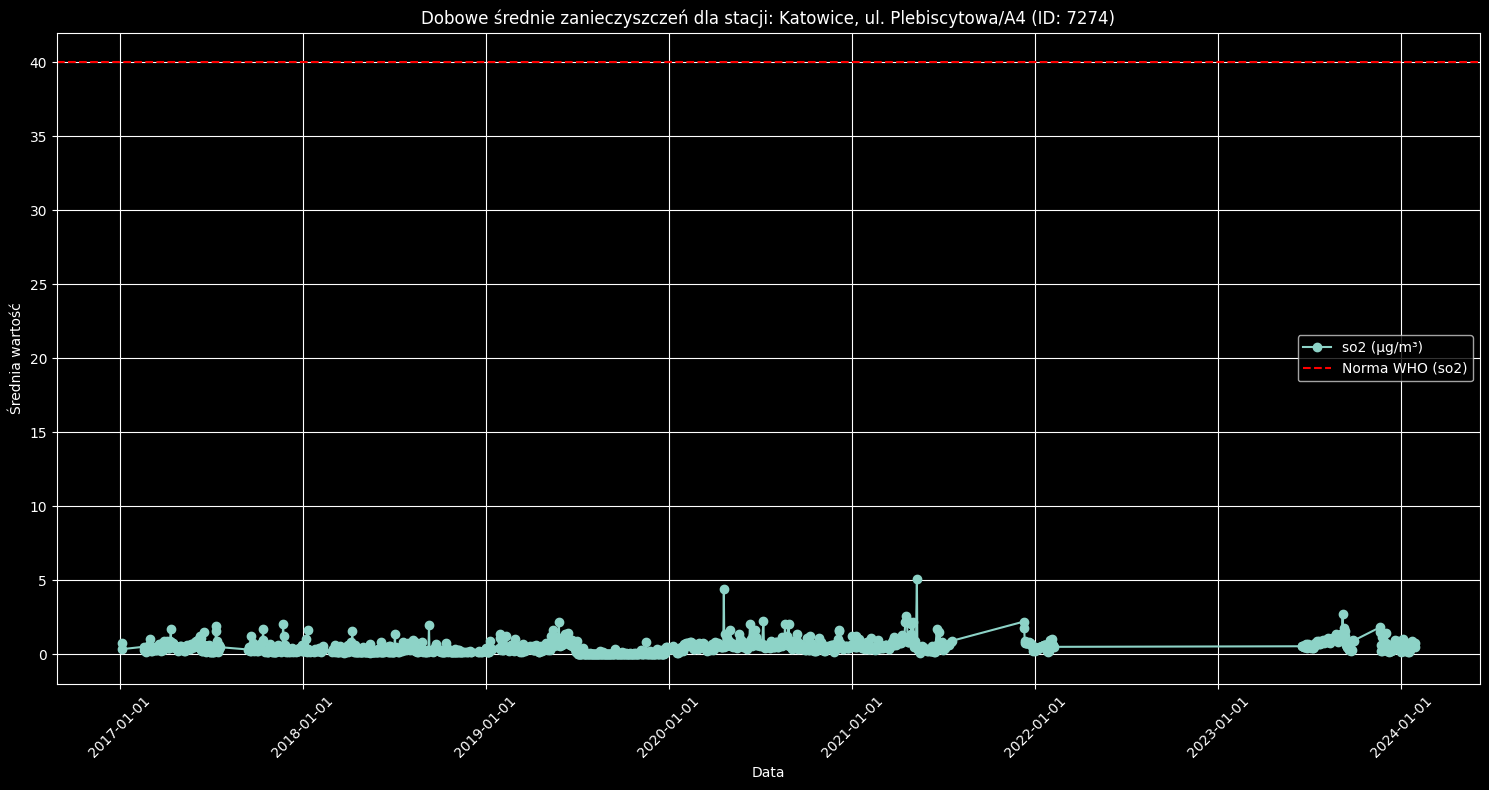

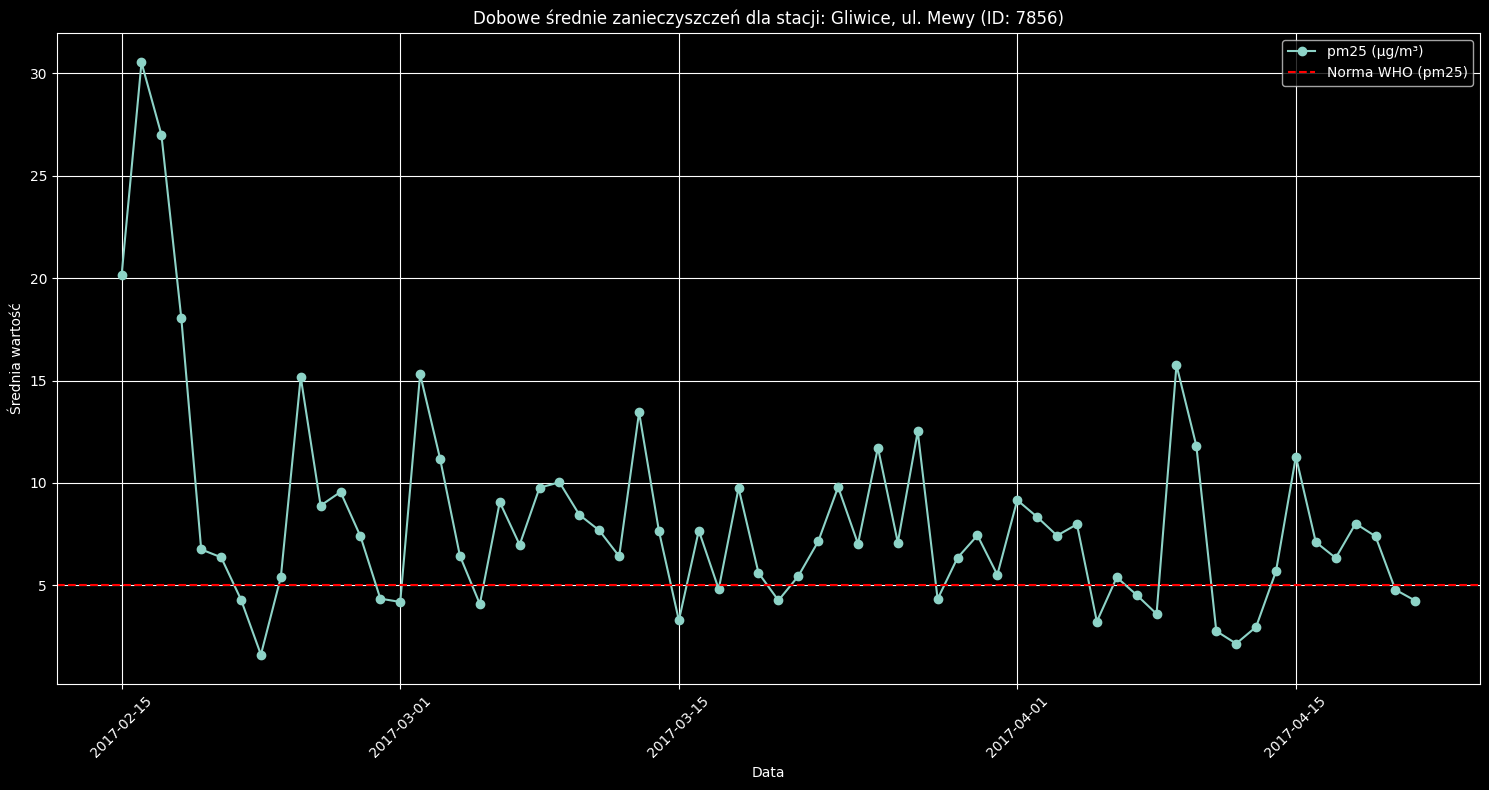

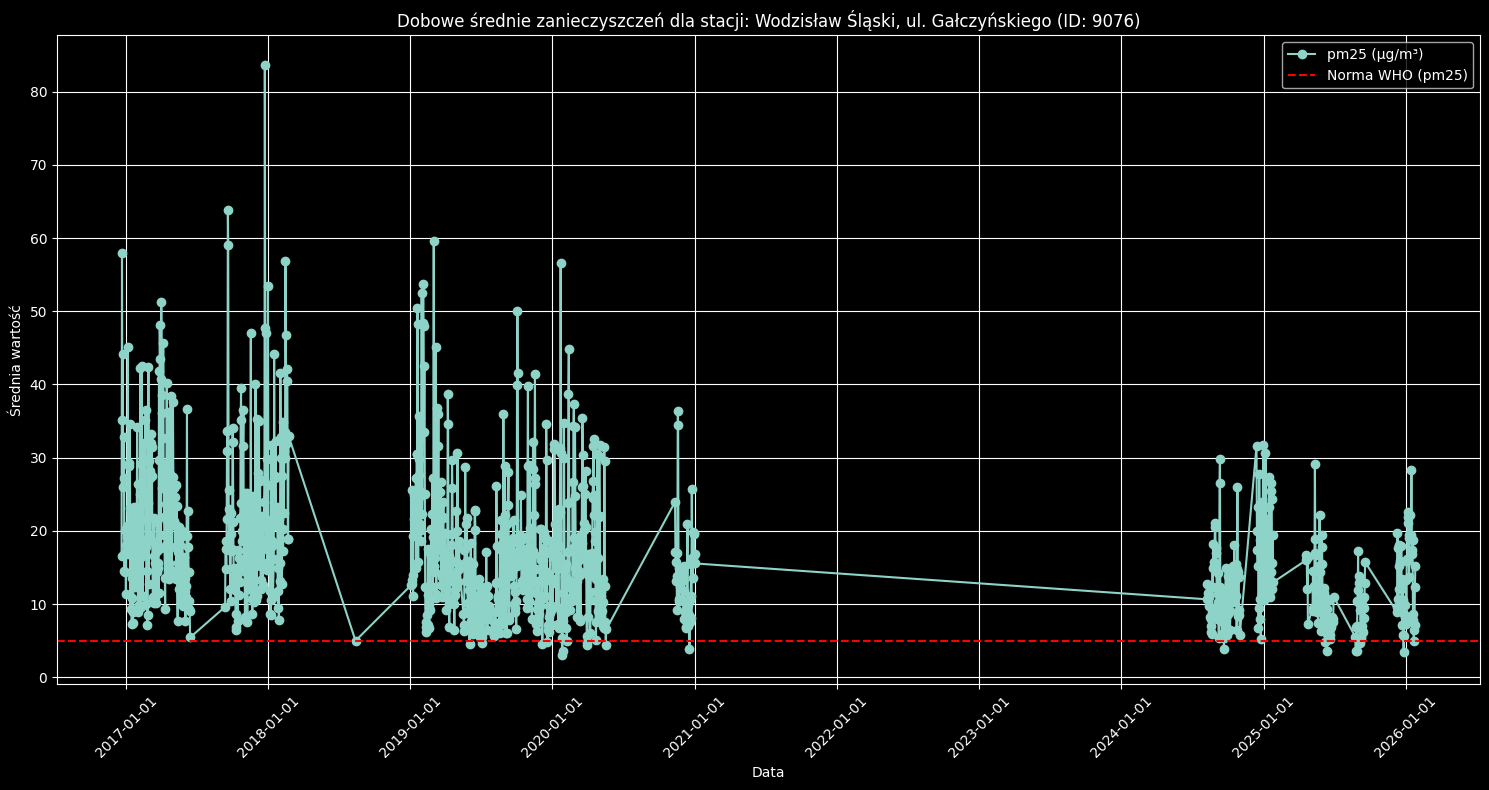

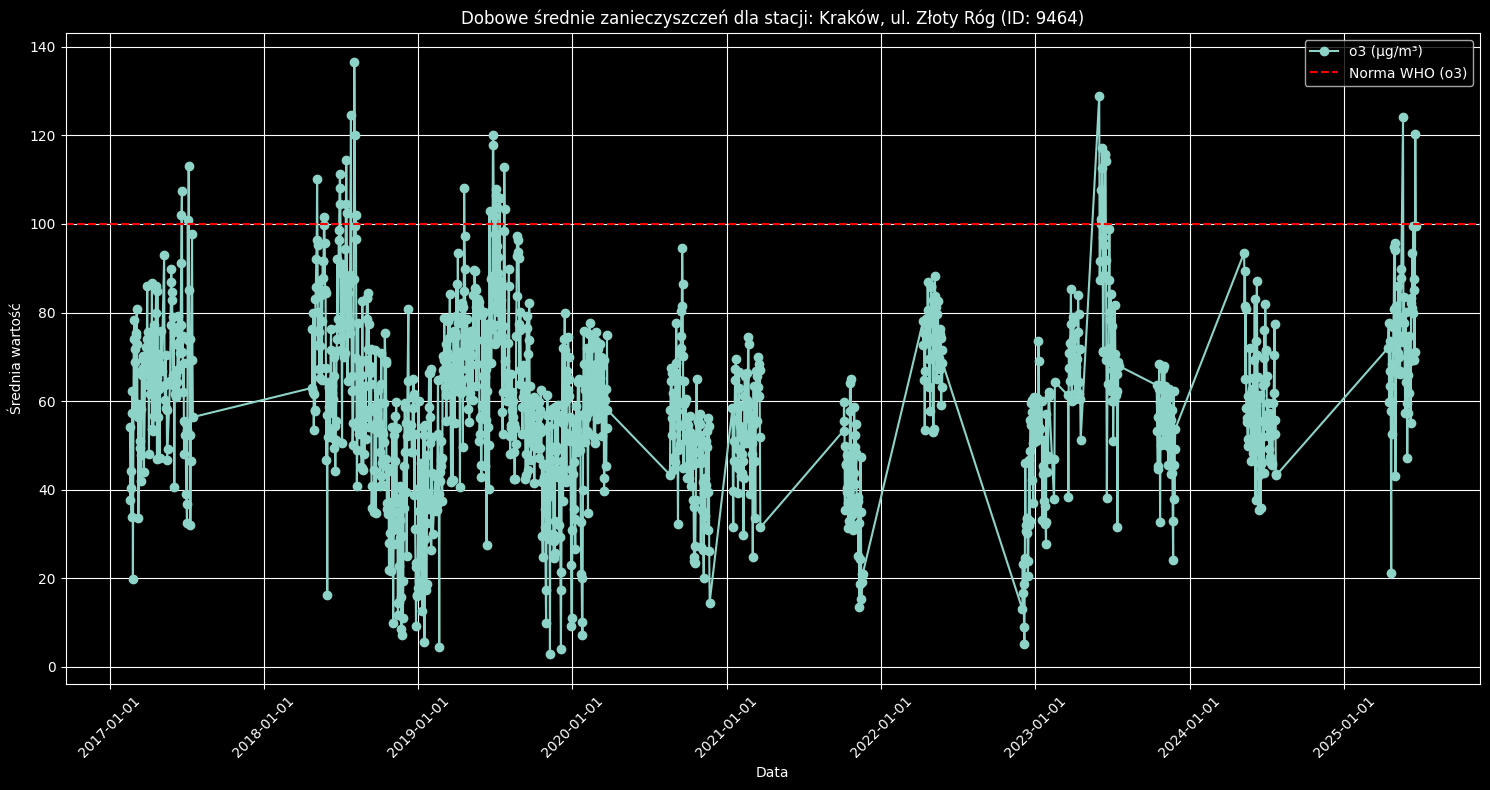

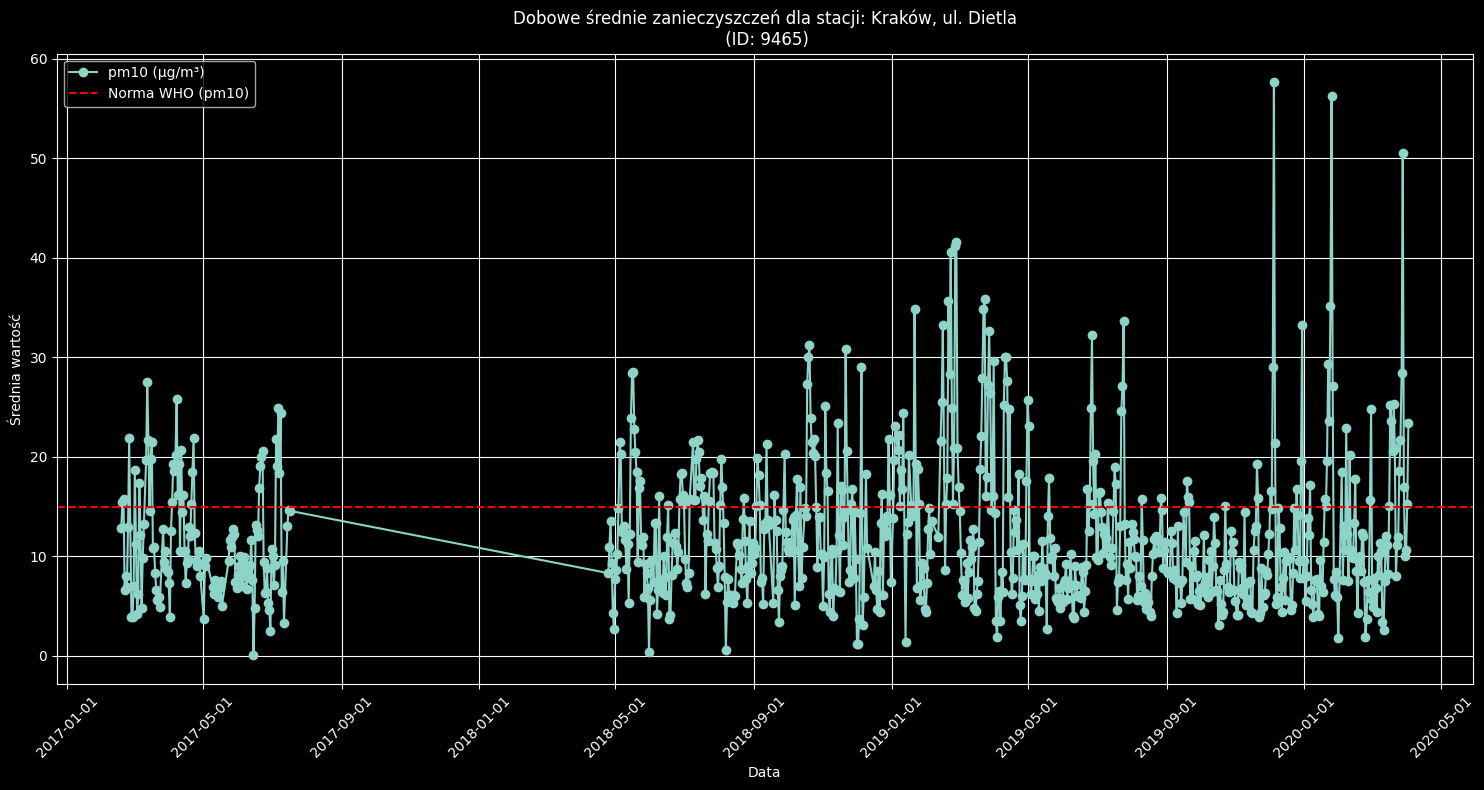

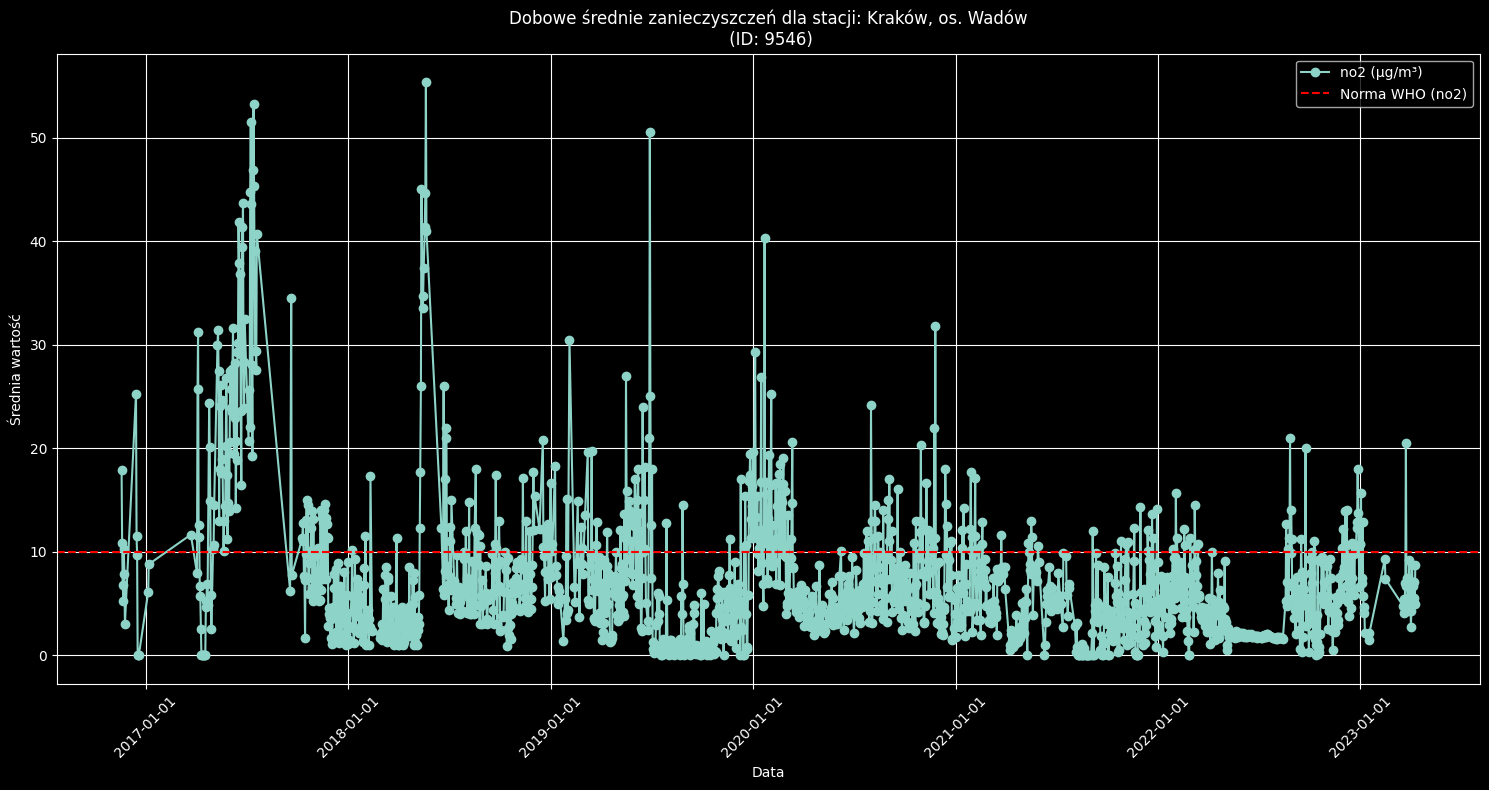

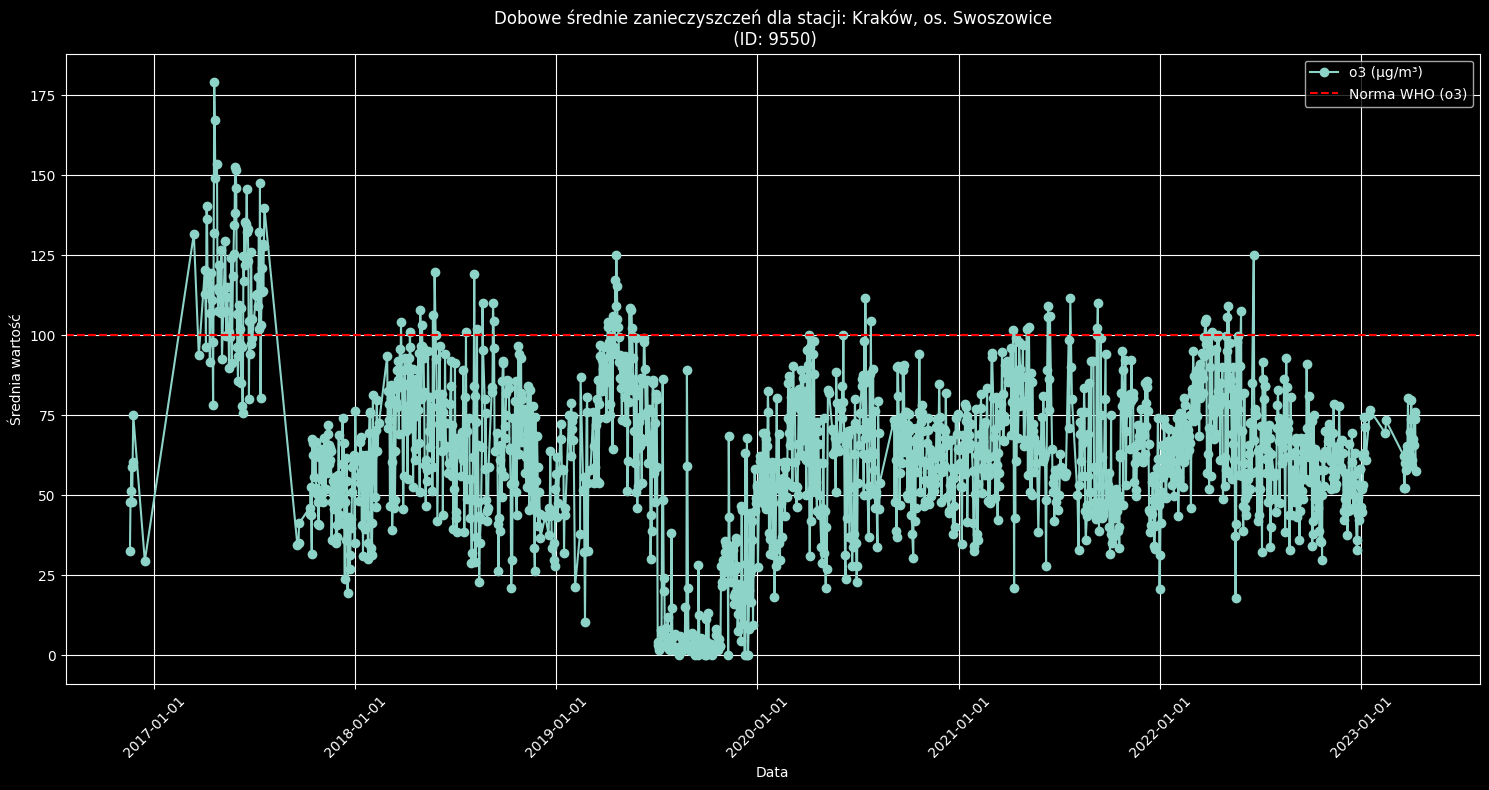

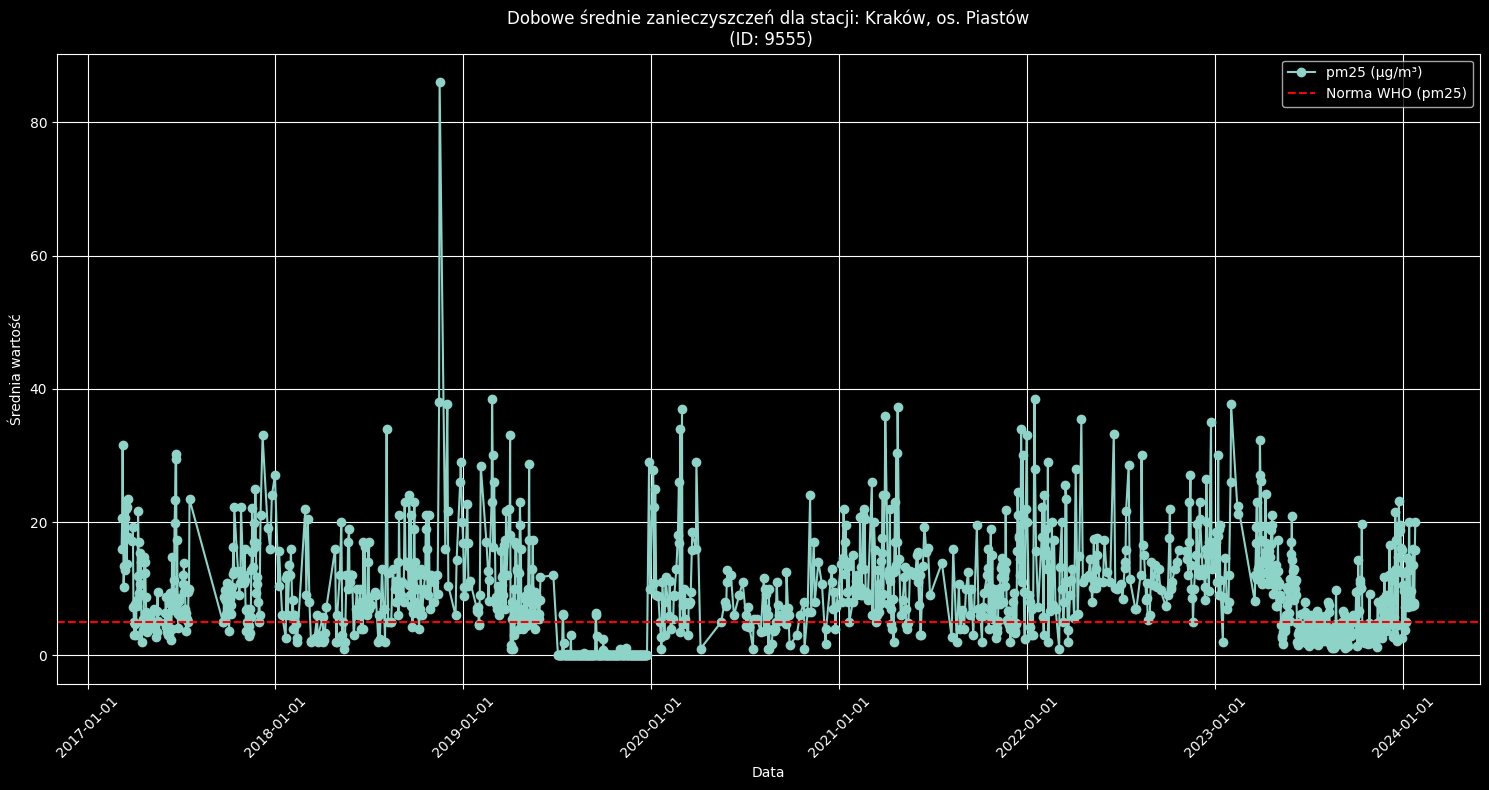

In [10]:
# Ustalenie unikalnych stacji i parametrów do wizualizacji
unique_stations = df['station_id'].unique()
unique_parameters = df['parameter'].unique()

print(f"Znaleziono stacje: {unique_stations}")
print(f"Znaleziono parametry: {unique_parameters}")

# Iteracja przez każdą stację i tworzenie wykresów dla każdego parametru
for station in unique_stations:
    station_df = df[df['station_id'] == station]
    station_name = station_df['name'].iloc[0] # Pobranie nazwy stacji
    
    # Ustawienie rozmiaru figury
    plt.figure(figsize=(15, 8))
    
    # Iteracja przez każdy parametr dla danej stacji
    for parameter in unique_parameters:
        param_df = station_df[station_df['parameter'] == parameter]
        
        if not param_df.empty:
            unit = param_df['unit'].iloc[0]
            plt.plot(param_df['day'], param_df['avg_value'], marker='o', linestyle='-', label=f'{parameter} ({unit})')
            
            # Słownik z przykładowymi normami jakości powietrza (wartości roczne WHO)
            # Uwaga: Jednostki muszą być zgodne z danymi (np. µg/m³)
            air_quality_norms = {
                'pm25': 5,      # Norma roczna WHO dla PM2.5
                'pm10': 15,     # Norma roczna WHO dla PM10
                'o3': 100,      # Norma 8-godzinna WHO dla Ozonu
                'no2': 10,      # Norma roczna WHO dla NO2
                'so2': 40,      # Norma 24-godzinna WHO dla SO2
                'co': 4000      # Norma 24-godzinna WHO dla CO (przeliczone z 4 mg/m³)
            }
            
            # Sprawdź, czy dla danego parametru istnieje zdefiniowana norma
            if parameter in air_quality_norms:
                norm_value = air_quality_norms[parameter]
                plt.axhline(y=norm_value, color='r', linestyle='--', label=f'Norma WHO ({parameter})')

    # Formatowanie wykresu
    plt.title(f'Dobowe średnie zanieczyszczeń dla stacji: {station_name} (ID: {station})')
    plt.xlabel('Data')
    plt.ylabel('Średnia wartość')
    plt.grid(True)
    plt.legend()
    
    # Formatowanie osi X, aby daty były czytelne
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    plt.tight_layout() # Dopasowanie, aby etykiety się nie nakładały
    plt.show()

### 5. Zamykanie połączenia

Na koniec zamykamy sesję i połączenie z klastrem.

In [11]:
session.shutdown()
cluster.shutdown()
print("Połączenie z Cassandra zostało zamknięte.")

Połączenie z Cassandra zostało zamknięte.
